# Opción 2 
https://www.kaggle.com/code/wanderdust/melanoma-detection/notebook

In [1]:
! python --version

Python 3.8.5


In [3]:
import tensorflow
import keras
print(tensorflow.__version__)
print(keras.__version__)

2.5.0
2.4.3


In [4]:
#! pip install tensorflow==2.5.0
# ! pip install pandas
# ! pip install numpy
# ! pip install seaborn
#! pip install keras==2.4.3

## Modelo: ResNet50

In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from IPython.display import display # Allows the use of display() for DataFrames
from time import time
import matplotlib.pyplot as plt
import seaborn as sns # Plotting library
import tensorflow.keras as keras
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from sklearn.datasets import load_files   
from collections import Counter

## 1. Load the data

In [6]:
#path = os.getcwd()

In [7]:
data_train_path = '/Users/inma/Desktop/tfg/datos_originales/train'
data_valid_path = '/Users/inma/Desktop/tfg/datos_originales/valid'
data_test_path = '/Users/inma/Desktop/tfg/datos_originales/test'

#data_train_path = path+ '/skin-lesions/train'
#data_valid_path = path+'/skin-lesions/valid'
#data_test_path = path+'/skin-lesions/test'

Visualization of the distribution

In [8]:
# define function to load train, test, and validation datasets
def load_data_raw (path):
    data = load_files(path)
    files = np.array(data['filenames'])
    targets = np_utils.to_categorical(np.array(data['target']), 3)
    
    return files, targets

train_filenames, train_targets = load_data_raw(data_train_path)

<BarContainer object of 3 artists>

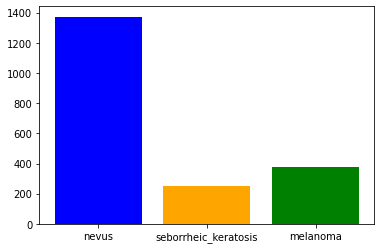

In [9]:
filenames_trimmed = [filename.split('/')[-2] for filename in train_filenames]
classes_count = Counter(filenames_trimmed)

# Plot the classes
plt.bar(classes_count.keys(), classes_count.values(), color=['blue', 'orange', 'green'])

Upsampling function for imbalanced data

In [10]:
def plot_n_samples(filenames):
    filenames_trimmed = [filename.split('/')[-2] for filename in filenames]
    classes_count = Counter(filenames_trimmed)

    # Plot the classes
    plt.bar(classes_count.keys(), classes_count.values(), color=['blue', 'orange', 'green'])

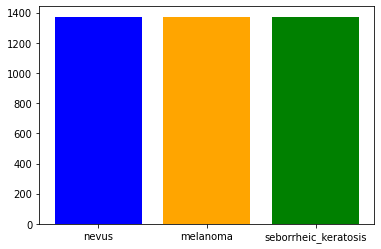

In [11]:
from sklearn.utils import resample, shuffle

# Choose one of the 3 for the feature_name
feature_names = {0: 'melanoma', 1: 'nevus', 2: 'seborrheic_keratosis'}

def upsample(filenames, targets, feature_name, n_samples = 1372):
    upsample_idx = []
    

    # Find all the indices for nevus
    for i, path in enumerate(filenames):
        # If feature matches, save the index
        if feature_name in path.split('/'):
            upsample_idx.append(i)
    
    # Remove selected features from filenames to add the upsampled after
    new_filenames = [filename for i, filename in enumerate(filenames) if i not in upsample_idx]
    new_targets = [target for i, target in enumerate(targets) if i not in upsample_idx]

    # Upsample
    resampled_x, resampled_y = resample(filenames[upsample_idx], targets[upsample_idx], n_samples=n_samples, random_state=0)

    # Add the upsampled features to new_filenames and new_targets
    new_filenames += list(resampled_x)
    new_targets += list(resampled_y) 
    
    return np.array(new_filenames), np.array(new_targets)
    
# We upsample twice: once for each feature we want upsampled
upsample_train_x, upsample_train_y = upsample(train_filenames, train_targets, feature_names[0])
upsample_train_x, upsample_train_y = upsample(upsample_train_x, upsample_train_y, feature_names[2])

plot_n_samples(upsample_train_x)

In [12]:
from keras.preprocessing import image   

# Convert the image paths to tensors Manually
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224,224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in img_paths]
    return np.vstack(list_of_tensors)


train_filenames = paths_to_tensor(upsample_train_x)
train_targets = upsample_train_y

Data augmentation

In [13]:
batch_size=32

# Transforms
datagen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.25,  # randomly shift images horizontally 
    height_shift_range=0.25,  # randomly shift images vertically
    horizontal_flip=True)

datagen_valid = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.25,  # randomly shift images horizontally
    height_shift_range=0.25,  # randomly shift images vertically
    horizontal_flip=True)

datagen_test = ImageDataGenerator(
    rescale=1./255)

Generators

In [14]:
# Generators
'''
train_generator = datagen_train.flow_from_directory(
        data_train_path,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical')
'''

train_generator = datagen_train.flow(train_filenames, train_targets, batch_size=batch_size)

valid_generator = datagen_valid.flow_from_directory(
        data_valid_path,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

test_generator = datagen_test.flow_from_directory(
        data_test_path,
        target_size=(224, 224),
        batch_size=1,
        class_mode='categorical',
        shuffle=False)

Found 150 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


In [15]:
num_train = len(train_filenames)
#num_train = len(train_generator.filenames)
num_valid = len(valid_generator.filenames)
num_test = len(test_generator.filenames)

print(num_train, num_valid, num_test)

4116 150 600


Get the class indices

To get the label we find the index of the 1 in the one hot encoded vector which should match the index in a dictionary. Eg:

- label = [1,0,0] ---> class_index = 0
- label = [0,1,0] ---> class_index = 1
- label = [0,0,1] ---> class_index = 2

In [16]:
# Class name to the index
#class_2_indices = train_generator.class_indices
class_2_indices = {'melanoma': 0, 'nevus': 1, 'seborrheic_keratoses': 2}
print("Class to index:", class_2_indices)

# Reverse dict with the class index to the class name
indices_2_class = {v: k for k, v in class_2_indices.items()}
print("Index to class:", indices_2_class)

Class to index: {'melanoma': 0, 'nevus': 1, 'seborrheic_keratoses': 2}
Index to class: {0: 'melanoma', 1: 'nevus', 2: 'seborrheic_keratoses'}


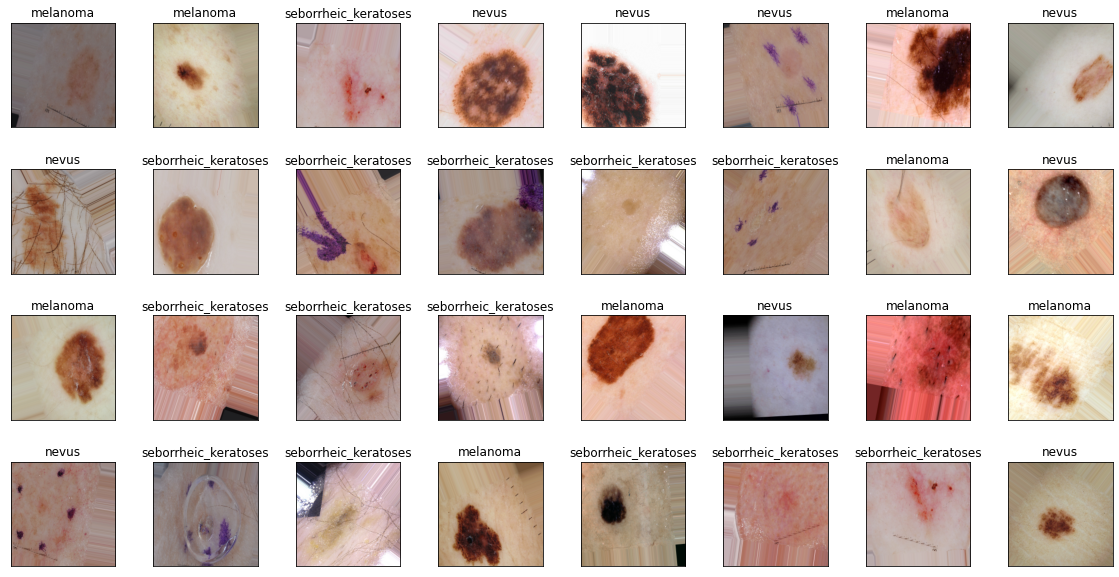

In [17]:
# Lets have a look at some of our images
images, labels = train_generator.next()

fig = plt.figure(figsize=(20,10))
fig.subplots_adjust(wspace=0.2, hspace=0.4)

# Lets show the first 32 images of a batch
for i, img in enumerate(images[:32]):
    ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(img)
    image_idx = np.argmax(labels[i])
    ax.set(title=indices_2_class[image_idx])

## 2. Create the model
Define the model architecture

In [35]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization, GlobalAveragePooling2D
#from keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.models import Model

base_model = ResNet50(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# x = MaxAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='elu')(x)
x = Dropout(0.80)(x)
# and a logistic layer
predictions = Dense(3, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
for layer in base_model.layers:
    layer.trainable = True

#model.summary()

Compile the model

In [36]:
from tensorflow.keras.optimizers import Adam

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy',
             metrics=['accuracy'])

/Users/inma/opt/anaconda3/envs/tfg/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


## 3.Train the model
Assign weights to imbalanced classes

The dataset shows an imbalance. By assigning bigger weights to the misrepresented classes in the dataset we will help to correct this issue.

In [39]:
from sklearn.utils import class_weight

# Convert one hot encoded labels to ints
train_targets_classes = [np.argmax(label) for label in train_targets]

# Compute the weights
class_weights = class_weight.compute_class_weight(#'balanced',
                                                    {0:2., 1:1., 2:1.},
                                                  classes=np.unique(train_targets_classes),
                                                  y=train_targets_classes)

class_weights_dict = dict(enumerate(class_weights))
print(class_weights_dict)

{0: 2.0, 1: 1.0, 2: 1.0}


Train the model

In [40]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# train the model
checkpointer = ModelCheckpoint(filepath='02_model.weights.best.hdf5', verbose=1, 
                               save_best_only=True)

scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=3, min_lr=1e-8, verbose=1)

early_stopper = EarlyStopping(monitor='val_loss', patience=10,
                              verbose=0, restore_best_weights=True)

history = model.fit_generator(train_generator,
                    class_weight= class_weights_dict,
                    steps_per_epoch=num_train//batch_size,
                    epochs=50,
                    verbose=0,
                    callbacks=[checkpointer, scheduler, early_stopper],
                    validation_data=valid_generator,
                    validation_steps=num_valid//batch_size)

/Users/inma/opt/anaconda3/envs/tfg/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '



Epoch 00001: val_loss improved from inf to 2.38534, saving model to 02_model.weights.best.hdf5

Epoch 00002: val_loss did not improve from 2.38534

Epoch 00003: val_loss improved from 2.38534 to 1.55422, saving model to 02_model.weights.best.hdf5

Epoch 00004: val_loss improved from 1.55422 to 1.53154, saving model to 02_model.weights.best.hdf5

Epoch 00005: val_loss improved from 1.53154 to 1.51724, saving model to 02_model.weights.best.hdf5

Epoch 00006: val_loss did not improve from 1.51724

Epoch 00007: val_loss improved from 1.51724 to 1.50015, saving model to 02_model.weights.best.hdf5

Epoch 00008: val_loss did not improve from 1.50015

Epoch 00009: val_loss improved from 1.50015 to 1.07419, saving model to 02_model.weights.best.hdf5

Epoch 00010: val_loss improved from 1.07419 to 0.73838, saving model to 02_model.weights.best.hdf5

Epoch 00011: val_loss did not improve from 0.73838

Epoch 00012: val_loss did not improve from 0.73838

Epoch 00013: val_loss did not improve from 

## 4. Test model
Load the model with the best Validation Accuracy

In [41]:
# load the weights that yielded the best validation accuracy
model.load_weights('02_model.weights.best.hdf5')

In [42]:
score = model.evaluate_generator(test_generator, steps=num_test//1, verbose=1)
print('\n', 'Test accuracy:', score[1])

/Users/inma/opt/anaconda3/envs/tfg/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1973: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


600/600 [==============================] - 213s 355ms/step - loss: 1.5101 - accuracy: 0.7550

 Test accuracy: 0.7549999952316284


Predictions for the test data

- task_1: the model's predicted probability that the image depicts melanoma
- task_2: the model's predicted probability that the image depicts seborrheic keratosis

In [43]:
predictions = model.predict_generator(test_generator, steps=num_test)

task_1 = pd.DataFrame(data=[desease[0] for desease in predictions])
task_2 = pd.DataFrame(data=[desease[2] for desease in predictions])

/Users/inma/opt/anaconda3/envs/tfg/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


RocAuc Score

In [44]:
from sklearn.metrics import roc_auc_score, accuracy_score

#ground_truth = pd.read_csv("../input/udacitydermatologistai/repository/udacity-dermatologist-ai-2ec0ca9/ground_truth.csv")
labels = np_utils.to_categorical(np.array(test_generator.classes), 3)

roc_auc_all = roc_auc_score(labels, predictions)
#roc_auc_task_1 = roc_auc_score(ground_truth['task_1'], task_1)
#roc_auc_task_2 = roc_auc_score(ground_truth['task_2'], task_2)

print('Roc auc score for all data is: {}'.format(roc_auc_all))
#print('Roc auc score for task 1 is: {}'.format(roc_auc_task_1))
#print('Roc auc score for task 2 is: {}'.format(roc_auc_task_2))

Roc auc score for all data is: 0.8495658131004961


Lets visualize some of our predictions

In [45]:
test_filenames, test_targets = load_data_raw(data_test_path)

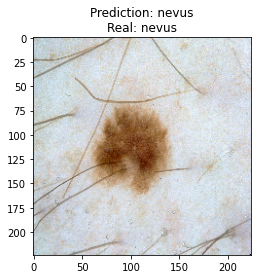

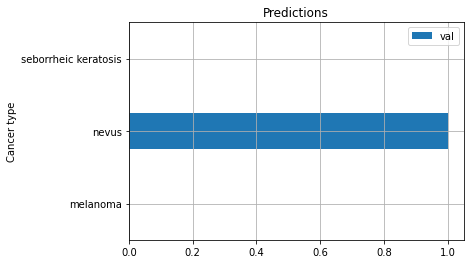

In [46]:
def plot_prediction(img_file, img_target):

    img = image.load_img(img_file, target_size=(224,224))
    img = image.img_to_array(img)/255
    img_expand = np.expand_dims(img, axis=0)
    
    # Make a prediction
    prediction = model.predict(img_expand, steps=1)
    image_idx = np.argmax(prediction[0])
    prediction_string = indices_2_class[image_idx]
    
    # Get the real label's name
    label_idx = np.argmax(img_target)
    real_label = indices_2_class[label_idx]
    
    # Plot predictions
    title = "Prediction: {}\nReal: {}".format(prediction_string, real_label)
    
    plt.imshow(img)
    plt.title(title)
    
    pred_df = pd.DataFrame({'Cancer type':['melanoma', 'nevus', 'seborrheic keratosis'], 'val':prediction[0]})
    ax = pred_df.plot.barh(x='Cancer type', y='val', title="Predictions", grid=True)
    
random_index = np.random.randint(0, len(test_generator.filenames))
plot_prediction(test_filenames[random_index], test_targets[random_index])

Performance curves

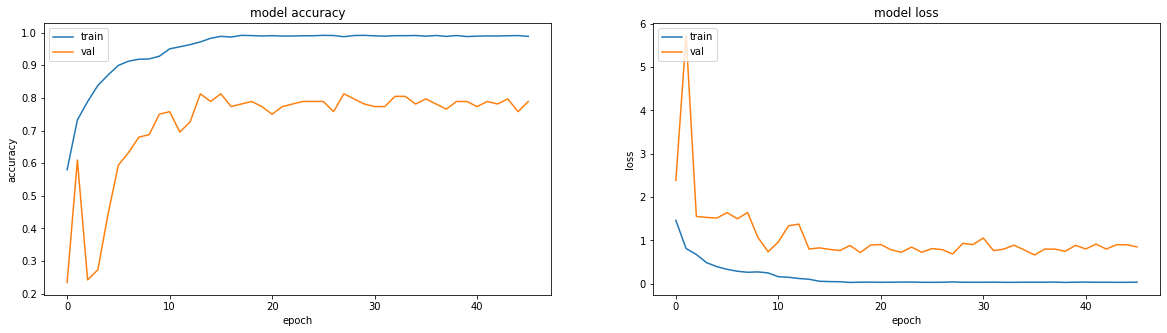

In [47]:
plts, (ax1, ax2) = plt.subplots(1,2, figsize=(20,5))

# summarize history for accuracy
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('model accuracy')
ax1.set(xlabel='epoch', ylabel='accuracy')
ax1.legend(['train', 'val'], loc='upper left')

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('model loss')
ax2.set(xlabel='epoch', ylabel='loss')
ax2.legend(['train', 'val'], loc='upper left')

Confusion Matrix

[Text(0, 0.5, 'melanoma'), Text(0, 1.5, 'nevus'), Text(0, 2.5, 'keratoses')]

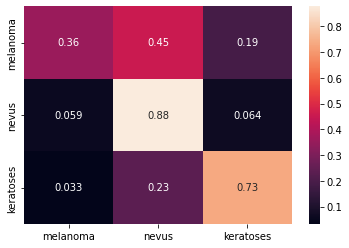

In [48]:
from sklearn.metrics import confusion_matrix

# Confusion matrix for all classes
y_true = test_generator.classes
y_pred = [np.argmax(x) for x in predictions]

labels = ["melanoma", "nevus", "keratoses"]
cm = confusion_matrix(y_true, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # Normalize confusion matrix
ax = sns.heatmap(cm, annot=True)
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

/Users/inma/opt/anaconda3/envs/tfg/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/inma/opt/anaconda3/envs/tfg/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


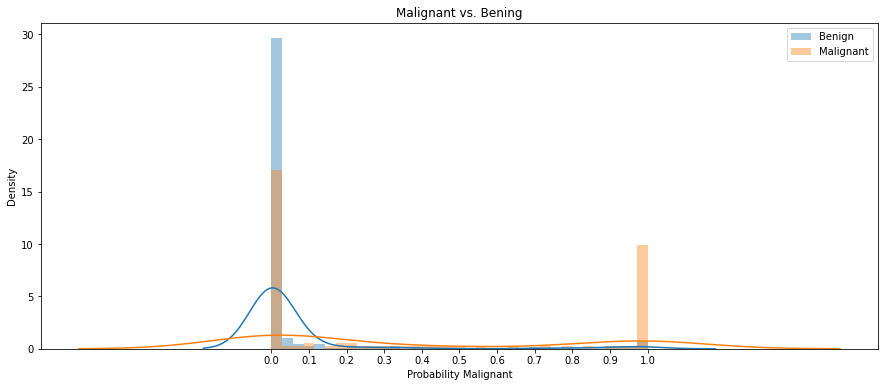

In [49]:
def plot_distribution(pred_target_y, filenames):
    melanoma_idx = []
      
    # Find all the indices for nevus
    for i, path in enumerate(filenames):
        # If feature matches, save the index
        if 'melanoma' in path.split('/'):
            melanoma_idx.append(i)
            
    bening_preds = [pred for i, pred in enumerate(pred_target_y) if i not in melanoma_idx]
    malignant_preds = [pred for i, pred in enumerate(pred_target_y) if i in melanoma_idx]
    
    fig, ax = plt.subplots(1,1,figsize=(15,6))
    
    ax.set_title('Malignant vs. Bening')
    sns.distplot(bening_preds, hist=True, kde=True, label="Benign", bins=35)
    sns.distplot(malignant_preds, hist=True, kde=True, label="Malignant", bins=35, axlabel="Probability Malignant")
    ax.legend()
    ax.xaxis.set_ticks(np.arange(0, 1.1, 0.1))

plot_distribution(task_1.values, test_generator.filenames)

In [50]:
model.save(
    'modelos/v2_model_02',
    overwrite=True,
)

/Users/inma/opt/anaconda3/envs/tfg/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: modelos/v2_model_02/assets
